In [1]:
# import modules 
%matplotlib inline
import pickle
import numpy as np
import sys
from scipy import stats
import random
import pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import host_subplot
from collections import defaultdict, Counter

path='/disks/qnap2/data/t-yatima/scisciJP2024_tutorial/'

# Import data

In [2]:
D = pickle.load(open(path+'D_values.pkl', 'rb')) 
# len(D) = 25,988,101
W = pickle.load(open(path+'teamsize_impact_disrup_refAge_refPop.pkl', 'rb')) 
# len(W) = 24,174,022

In [28]:
display(D[:5], W[:5])
display(len(D), len(W))

[0.0048543689320388345,
 0.023809523809523808,
 0.0026785714285714286,
 -0.04225352112676056,
 -0.03597122302158273]

[[1, 3, 0.0045662100456621, 2.12195121951, 8.5],
 [2, 5, -0.0005822981366459627, 2.45911949686, 17.0],
 [1, 3, -0.00023282887077997672, 1.74468085106, 17.0],
 [1, 2, -0.0007238508867173362, 3.33870967742, 23.0],
 [1, 1, -0.0007763975155279503, 2.74193548387, 18.5]]

25988101

24174022

In [20]:
print(matplotlib.__version__)

NameError: name 'matplotlib' is not defined

# Figure 1b

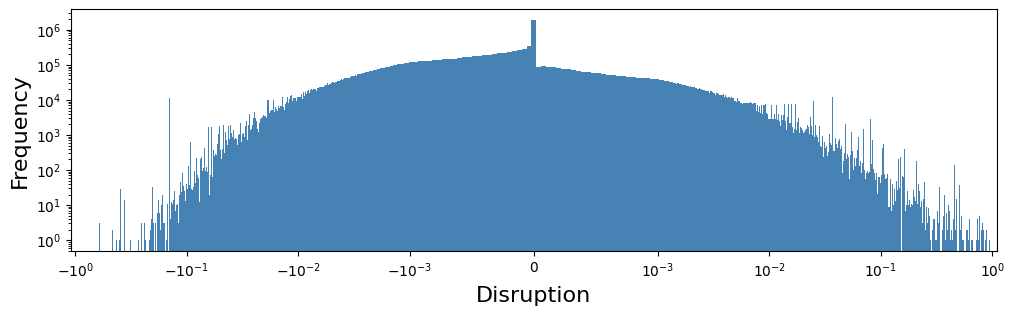

In [22]:
nbins=50000
fig = plt.figure(figsize=(10, 3),facecolor='white')
ax = fig.add_subplot(111)
#
N, bins, patches = ax.hist(D, bins=nbins,edgecolor='white', linewidth=0)
LN=np.log(max(N))


# Find fractions of small natural denominator and make them less distractive
delta=bins[1]-bins[0]
peaks=set([j/i for i in range(1,100) for j in range(1,i)]+\
[-j/i for i in range(1,100) for j in range(1,i)]) 
ys=dict((i,(patches[i-1]._height+patches[i+1]._height)*0.5) \
        for i in range(1,len(N)-2)) #smooth color

for i,z in zip(range(0,nbins),bins):
    if patches[i]._height>0: # only plot patches with values
        r=(np.log(patches[i]._height)/LN)**5 # transparency scales to y values
        for p in peaks:
            if z<p<z+delta and 0<i<len(N):
                r=(np.log(ys[i]+1)/LN)**5 # disruption fraction
        patches[i].set_alpha(1)
        patches[i].set_facecolor(color='SteelBlue')

#
plt.yscale('log')
plt.xscale('symlog',linthresh=0.001)
plt.tight_layout()
plt.xlabel('Disruption',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
#plt.savefig(path+'Fig1b.pdf')
plt.show()

# Figure 2a

In [3]:
len(W)

24174022

In [4]:
W=random.sample(W,1000000)
display(len(W), W[:5])

1000000

[[7, 6, -0.0005908419497784342, 5.88888888889, 35.0],
 [3, 8, -0.015748031496062992, 10.5384615385, 18.5],
 [1, 4, 0.009411764705882352, 8.5, 211.0],
 [5, 5, -0.013043478260869565, 14.75, 23.5],
 [4, 44, -0.0016802688430148825, 10.9285714286, 145.0]]

In [5]:
teamsize,impact,disruption,referenceAge, referencePopularity = np.array(W).T

In [6]:
#aggregate data by team size
impPaper=defaultdict(lambda:[])
disPaper=defaultdict(lambda:[])
depPaper=defaultdict(lambda:[])
popPaper=defaultdict(lambda:[])
for ts,imp,disrupt,refAge, refPop in W:
    if 1<=ts<=10:
        impPaper[ts].append(imp)
        disPaper[ts].append(disrupt)
        depPaper[ts].append(refAge)
        popPaper[ts].append(refPop)

In [7]:
DisruptionPaper=random.sample(list(disruption),10000)
stats.percentileofscore(DisruptionPaper,0)#test with zero value , which should be around ~70

70.3

In [8]:
# flush print to track computation time
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(d)
    sys.stdout.flush()
    
# calculate CI using bootstrap
def calculateCI(dic,method,n):
    ci=[]
    for teamsize in range(1,11):
        data=dic[teamsize]
        m=int(len(data)/10) #take 10% data
        ms=[]
        for j in range(n): #number of samples
            flushPrint(str(teamsize)+'_'+str(j))
            if method=='mean':
                    ms.append(np.mean(np.random.choice(data,m)))
            if method=='median':
                    ms.append(np.median(np.random.choice(data,m)))
        a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
        ci.append([a,b])
    a,b=np.array(ci).T
    return a,b

In [10]:
# mean
xdisPaper,ydisPaper=np.array(sorted([(k,np.mean(v)) for k,v in disPaper.items()])).T
ximpPaper,yimpPaper=np.array(sorted([(k,np.mean(v)) for k,v in impPaper.items()])).T
# CI
ydisPaperCIa,ydisPaperCIb=calculateCI(disPaper,'mean',50)
yimpPaperCIa,yimpPaperCIb=calculateCI(impPaper,'mean',50)
#percentile
ydisPaper=[stats.percentileofscore(DisruptionPaper,i) for i in ydisPaper]
ydisPaperCIa=[stats.percentileofscore(DisruptionPaper,i) for i in ydisPaperCIa]
ydisPaperCIb=[stats.percentileofscore(DisruptionPaper,i) for i in ydisPaperCIb]

10_49

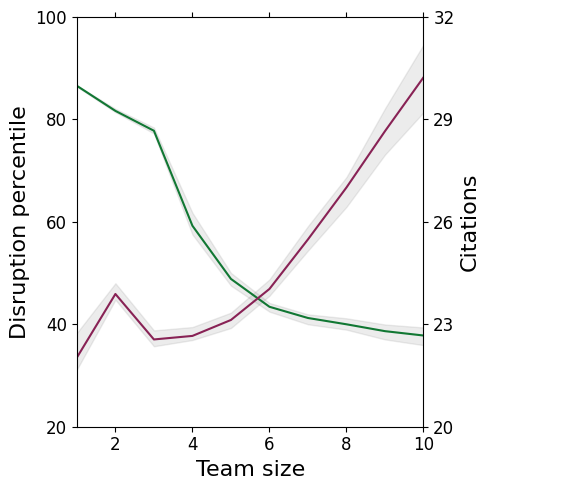

In [11]:
fig = plt.figure(figsize=(5,5),facecolor='white')

host = host_subplot(111)
plt.subplots_adjust(right=1)
host.tick_params(axis='x', which='both',bottom='on',top='off')
par1 = host.twinx()

host.plot(xdisPaper,ydisPaper, label="Disruption",color='#117733')
par1.plot(ximpPaper,yimpPaper, label="Impact",color='#882255')
host.fill_between(range(1,11), ydisPaperCIa,ydisPaperCIb,color='gray',alpha=0.15)
par1.fill_between(range(1,11), yimpPaperCIa,yimpPaperCIb,color='gray',alpha=0.15)

host.set_xlim(1, 10)
host.set_ylim(20,100)
host.set_yticks([20,40,60,80,100])
par1.set_ylim(20,32)
par1.set_yticks([20,23,26,29,32])
host.set_xlabel('Team size',size=16)
host.set_ylabel('Disruption percentile',size=16)
par1.set_ylabel('Citations',size=16)
host.tick_params(axis='both', which='major', labelsize=12)
par1.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
#plt.savefig('~/Fig2a.pdf')

# Figure 2d

In [12]:
r=95
a1,a2,a3,a4=np.percentile(impact,r),np.percentile(disruption,r),\
np.percentile(referenceAge,r),np.percentile(referencePopularity,r)

top5Paper=[]
for ts in range(1,11):
    ratio1=len([i for i in impPaper[ts] if i>=a1])/float(len(impPaper[ts]))
    ratio2=len([i for i in disPaper[ts] if i>=a2])/float(len(disPaper[ts]))
    ratio3=len([i for i in depPaper[ts] if i>=a3])/float(len(depPaper[ts]))
    ratio4=len([i for i in popPaper[ts] if i>=a4])/float(len(popPaper[ts]))
    top5Paper.append([ts,ratio1,ratio2,ratio3,ratio4])

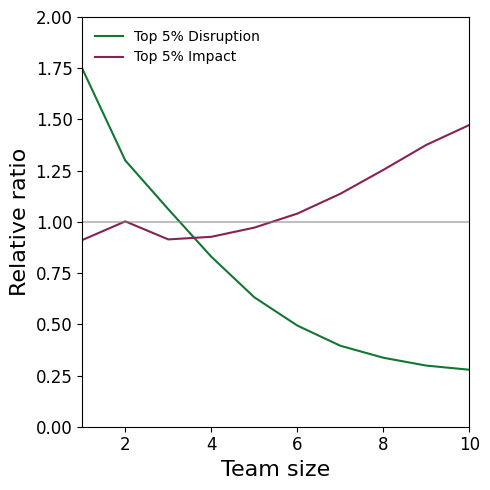

In [13]:
tss,r1,r2,r3,r4=np.array(top5Paper).T
fig = plt.figure(figsize=(5, 5),facecolor='white')

ratio=1-r/100.0

host = host_subplot(111)
plt.plot(tss,r2/ratio,color='#117733',label='Top 5% Disruption')
plt.plot(tss,r1/ratio,color='#882255',label='Top 5% Impact')
plt.xlabel('Team size',fontsize=16)
plt.ylabel('Relative ratio',fontsize=16)
plt.plot([1,100],[1,1],color='gray',linestyle='-',alpha=0.5)
plt.xlim(1,10)
plt.ylim(0,2)
host.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc=2,numpoints=1,fontsize=10,frameon=False)
plt.tight_layout()

#plt.savefig('~/Fig2d.pdf')

# Figure 3a

In [9]:
np.percentile(impact,10),np.percentile(impact,50),np.percentile(impact,75),\
np.percentile(impact,90),np.percentile(impact,95) #(1.0, 10.0, 24.0, 53.0, 84.0)

(1.0, 10.0, 24.0, 52.0, 84.0)

In [10]:
DisImpact=defaultdict(lambda:defaultdict(lambda:[]))
n=0
for teamsize,impact,disruption,referenceAge, referencePopularity in W:
    n+=1
    if n%100000==0:
        flushPrint(str(n/100000))
    if 1<=teamsize<=10 and impact>0:
        if impact<=1:
            ilevel=1
        if 1<impact<10:
            ilevel=2
        if 10<=impact<24:
            ilevel=3           
        if 24<=impact<53:
            ilevel=4           
        if 53<=impact<84:
            ilevel=5
        if impact>=84:
            ilevel=6
        DisImpact[ilevel][teamsize].append(disruption)


1.0

10.0

In [11]:
disImpact={}
disImpact1={}
for ilevel in [1,2,3,4,5,6]:
    disImpact[ilevel]=sorted([(k,stats.percentileofscore(DisruptionPaper, np.mean(v)))\
                                   for k,v in DisImpact[ilevel].items()])
    disImpact1[ilevel]=sorted([(k,np.mean(v)) for k,v in DisImpact[ilevel].items()])

/tmp/ipykernel_731486/3791629456.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = cm.get_cmap('summer_r',7)


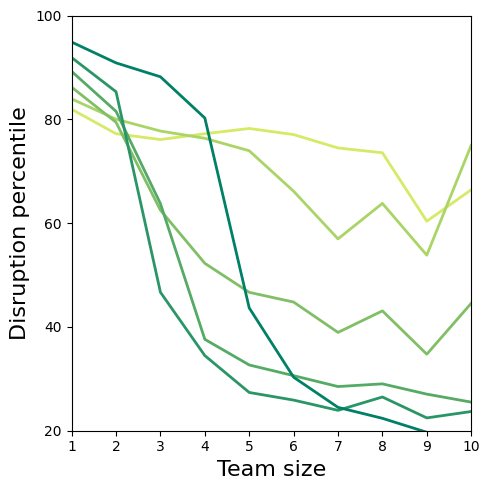

In [12]:
fig = plt.figure(figsize=(5,5),facecolor='white')
cmap1 = cm.get_cmap('summer_r',7)
ax = fig.add_subplot(111)
ip={1:'0-10',2:'10-50',3:'50-75',4:'75-90',5:'90-95',6:'95-100'}
for ilevel in [1,2,3,4,5,6]:
    x,y=np.array(disImpact[ilevel]).T
    plt.plot(x,y,color=cmap1(ilevel),linewidth=2,alpha=1,label=ip[ilevel])
ax.set_xlim(1,10)
ax.set_ylim(20,100)
ax.set_yticks([20,40,60,80,100])
plt.xlabel('Team size',fontsize=16)
plt.ylabel('Disruption percentile',fontsize=16)

plt.tight_layout()
#plt.savefig('~/Fig3a.pdf')

# Figure 4a

In [18]:
xdepPaper,ydepPaper=np.array(sorted([(k,np.mean(v)) for k,v in depPaper.items()])).T
xpopPaper,ypopPaper=np.array(sorted([(k,np.median(v)) for k,v in popPaper.items()])).T

ydepPaperCIa,ydepPaperCIb=calculateCI(depPaper,'mean',50)
ypopPaperCIa,ypopPaperCIb=calculateCI(popPaper,'median',50)

3_999

KeyboardInterrupt: 

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


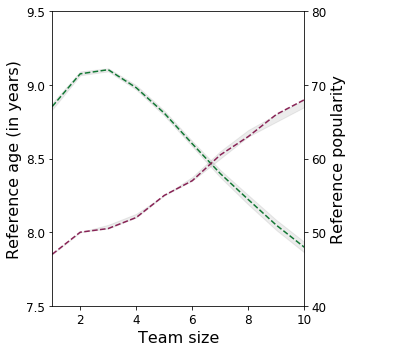

In [ ]:
fig = plt.figure(figsize=(5,5),facecolor='white')
#------------main figure 122-------------------

host = host_subplot(111)
plt.subplots_adjust(right=1)
host.tick_params(axis='x', which='both',bottom='on',top='off')
par1 = host.twinx()

host.plot(xdepPaper,ydepPaper, label="Disruption",color='#117733',linestyle='--')
par1.plot(xpopPaper,ypopPaper, label="Impact",color='#882255',linestyle='--')
host.fill_between(range(1,11), ydepPaperCIa,ydepPaperCIb,color='gray',alpha=0.15)
par1.fill_between(range(1,11), ypopPaperCIa,ypopPaperCIb,color='gray',alpha=0.15)


host.set_xlim(1, 10)
host.set_ylim(7.5, 9.5)
host.set_yticks([7.5,8.0,8.5,9.0,9.5])
par1.set_ylim(40,80)
par1.set_yticks([40,50,60,70,80])
host.tick_params(axis='both', which='major', labelsize=12)
par1.tick_params(axis='both', which='major', labelsize=12)
host.set_xlabel('Team size',fontsize=16)
host.set_ylabel('Reference age (in years)',fontsize=16)
par1.set_ylabel('Reference popularity',fontsize=16)

plt.tight_layout()
#plt.savefig('~/Fig4a.pdf')

# Figure 4d

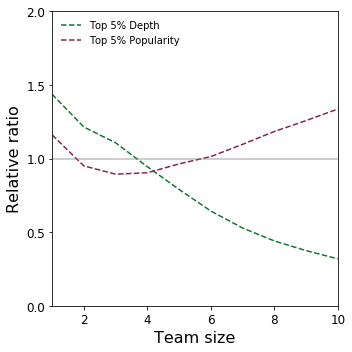

In [ ]:
tss,r1,r2,r3,r4=np.array(top5Paper).T
fig = plt.figure(figsize=(5, 5),facecolor='white')

ratio=1-r/100.0
host = host_subplot(111)
plt.plot(tss,r3/ratio,color='#117733',linestyle='--',label='Top 5% Depth')
plt.plot(tss,r4/ratio,color='#882255',linestyle='--',label='Top 5% Popularity')
plt.xlabel('Team size',fontsize=16)
plt.ylabel('Relative ratio',fontsize=16)
plt.plot([1,100],[1,1],color='gray',linestyle='-',alpha=0.5)
plt.xlim(1,10)
plt.yticks([0,0.5,1,1.5,2.0])
plt.ylim(0,2)
host.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc=2,numpoints=1,fontsize=10,frameon=False)
plt.tight_layout()

#plt.savefig('~/Fig4d.pdf')